I need to compare the kT at certain regions using the FES, and make it similar to the paper I made for David in the chemical reviews paper. For this, I will copy what I did on `sugar_snapshot_prep` and take regions that are close to structures, or I can choose it myself and map it to the FES.


Only difference between this and `sugar_snapshot_prep` is that I then take the kT from these regions

In [1]:
import os
import pickle
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logging.getLogger("matplotlib.pyplot").setLevel(logging.ERROR)

logging.getLogger("stringmethod").setLevel(logging.ERROR)
sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

2022-03-30 09:50:51 root-INFO: Setting up logging for gmxapi package.
2022-03-30 09:50:51 gmxapi-INFO: Importing gmxapi.
2022-03-30 09:50:51 gmxapi.operation-INFO: Importing gmxapi.operation
2022-03-30 09:50:51 gmxapi.commandline-INFO: Importing gmxapi.commandline
2022-03-30 09:50:51 gmxapi.simulation.workflow-INFO: Importing gmx.workflow
2022-03-30 09:50:51 gmxapi.simulation.workflow-INFO: Using schema version gmxapi_workspec_0_1.
2022-03-30 09:50:51 gmxapi.mdrun-INFO: Importing gmxapi.simulation.mdrun
2022-03-30 09:50:51 gmxapi.read_tpr-INFO: Importing gmxapi.simulation.read_tpr
2022-03-30 09:50:51 gmxapi.modify_input-INFO: Importing gmxapi.simulation.modify_input
2022-03-30 09:50:51 stringmethod-0-INFO: Using 1 MPI ranks 


In [2]:
MSM_sim_dir = "../../string_sims/TMD_initial_path/influx_BFRU_gate_CV"

F = np.load(f'{MSM_sim_dir}/F_MSM.npy')
extent = np.load(f'{MSM_sim_dir}/extent_MSM.npy')
cv_proj = np.load(f'{MSM_sim_dir}/cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

In [3]:
def get_G5_atomistic_gate(timestep):
    # get all pieces together, then colors and naming consistent in plots
    G5_Out = np.array(['OUT', 'Out Open', 'green', "Greens"])
    G5_OutOcc = np.array(['OUT-OCC', 'Out Occ.', 'grey', "Greys"])
    G5_Occ = np.array(['OCC', 'Occluded', 'red', "Reds"])
    G5_InOcc = np.array(['IN-OCC', 'In Occ.', 'orange', "Oranges"])
    G5_In = np.array(['IN', 'In Open', 'blue', "Blues"])
    all_sims = np.array([G5_Out, G5_OutOcc, G5_Occ, G5_InOcc, G5_In])

    indir = '/data2/GLUT5_string/string/analysis/textfiles_out/EC_IC_gate_refs'

 
    out_arr = []
    for n, sim in enumerate(all_sims):
        name = sim[0]
        ec = np.loadtxt(f"{indir}/{name}.EC.{timestep}.xvg")[1]
        ic = np.loadtxt(f"{indir}/{name}.IC.{timestep}.xvg")[1]
        
        
        temp = np.append(all_sims[n], [f'EC: {str(ec)}', f'IC: {str(ic)}'])
        out_arr.append(temp)

    out_arr = np.array(out_arr)
    return out_arr

In [4]:
plot_atomistic = True
name = 'start_model'
#name = 'end_atom'
atom_sims = get_G5_atomistic_gate(name)

In [5]:
def get_F_at_square(IC_leftmost,IC_rightmost,EC_lowermost,EC_uppermost):
    IC_extent = np.linspace(extent[0], extent[1], 55)
    EC_extent = np.linspace(extent[2], extent[3], 55)

    F_col = np.where(np.logical_and(IC_extent>=IC_leftmost, IC_extent<=IC_rightmost))[0]
    F_row = np.where(np.logical_and(EC_extent>=EC_lowermost, EC_extent<=EC_uppermost))[0]

    print(F_row,F_col)

    F_indices_at_square = []
    F_values_at_square = []
    for x_val in F_row:
        for y_val in F_col:
            F_indices_at_square.append([x_val,y_val])
            F_values_at_square.append(F[x_val,y_val])
            
      
    return F_values_at_square, F_indices_at_square

Here I make the plot visible and moveable so that we can easily zoom in or see the square regions we want to take

2022-03-30 10:28:45 matplotlib.colorbar-DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6aabdc4d00>
2022-03-30 10:28:45 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6aabdc4d00> on colorbar
2022-03-30 10:28:45 matplotlib.colorbar-DEBUG: Setting pcolormesh


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
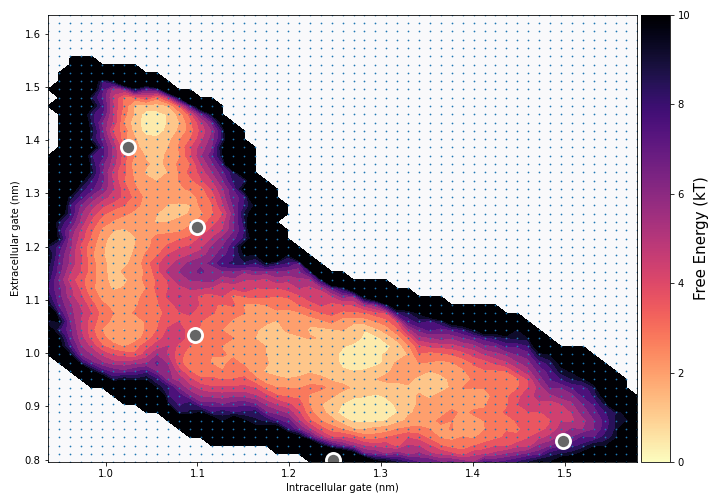

In [75]:
%matplotlib widget

f_max = 10


fig, ax = my_msm.plot_2D_heatmap(
    F, 
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= None,
    ylim= None,
    cmap = plt.cm.magma_r,
    
)


markers = ['o','o','o','o','o']
sizes = [200,200,200,200,200]
if plot_atomistic:
    for n, sim in enumerate(atom_sims):
        ic = float(sim[-1].split(' ')[1])
        ec = float(sim[-2].split(' ')[1])
        ax.scatter(ic, ec, color = ['#666666'], edgecolor = 'white', \
                   s = sizes[n], zorder=2, marker = markers[n], linewidth = 2.8)

        
## so that you can see where F will be caught        
IC = np.linspace(extent[0],extent[1],55)
EC = np.linspace(extent[2],extent[3],55)
xx,yy = np.meshgrid(IC,EC)
ax.scatter(xx,yy,s = 0.53)
plt.show()

In [82]:
structures_as_wells = False

margin = 0.015

if not structures_as_wells:
    if 'BFRU' in MSM_sim_dir:
        wells_borders = {'out_open':[1.04, 1.067, 1.411, 1.457],\
                         'out_occluded':[1.064,1.0846, 1.258,1.2812],\
                        "pre_occluded":[1.0, 1.036, 1.017, 1.07], \
                        "occluded":[1.065,1.093,1.055, 1.08], \
                        "in_occluded_high":[1.25, 1.29, 0.98,1.02],
                        "near_in_open":[1.45, 1.48, 0.85, 0.88]}
    
    elif 'apo' in MSM_sim_dir:
        wells_borders = {'out_open':[1.04, 1.067, 1.401, 1.457] }

     
    
else:
    wells_borders = {}
    for n, sim in enumerate(atom_sims):
        ic = float(sim[-1].split(' ')[1])
        ec = float(sim[-2].split(' ')[1])
    
        wells_borders[sim[0]] = [ic-margin, ic+margin, ec-margin, ec+margin]

In [83]:
projection_F = np.zeros(np.shape(F))
projection_F[projection_F == 0] = np.nan
wells_energies = {}
wells_F_coords = {}

for sim, square in wells_borders.items():
    temp_energy, temp_coord = get_F_at_square(IC_leftmost = square[0],
                                IC_rightmost = square[1],
                                EC_lowermost = square[2],
                                EC_uppermost = square[3])
    wells_energies[sim] = [np.mean(temp_energy), np.std(temp_energy)]
    wells_F_coords[sim] = temp_coord
    for n, coord in enumerate(temp_coord):
        projection_F[coord[0]][coord[1]] = temp_energy[n]

[40 41 42] [ 9 10]
[30 31] [11 12]
[15 16 17] [6 7 8]
[17 18] [11 12 13]
[12 13 14] [27 28 29]
[4 5] [44 45]


Here you can see where on the grid the energies are being taken, so you are sure you are taking from the right area

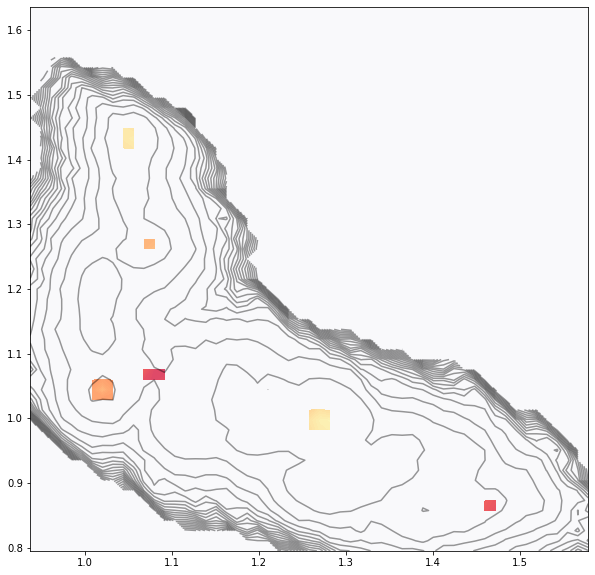

In [84]:
%matplotlib inline 

with plt.rc_context({"axes.grid": False}):
    f, ax = plt.subplots(figsize = (10,10))
    ax.contourf(projection_F, extent = extent, vmin = 0, vmax = 10, levels = 50, cmap = 'magma_r')
    ax.contour(F, extent = extent, colors = 'black', vmin = 0, vmax = 5, levels = 20, alpha = 0.4)

In [74]:
wells_energies

{'OUT': [2.309666493782509, 0.6353595582462312],
 'OUT-OCC': [2.720320566396882, 0.48238996755381824],
 'OCC': [3.396074729678185, 0.274321014356606],
 'IN-OCC': [21.553090844212452, 7.5021593091190395],
 'IN': [6.306299033432075, 0.8401301297904091]}

In [38]:
for n,x in enumerate(np.ravel(F)):
    print(n, np.floor(n /55), '      ', x)

0 0.0        nan
1 0.0        nan
2 0.0        nan
3 0.0        nan
4 0.0        nan
5 0.0        nan
6 0.0        nan
7 0.0        nan
8 0.0        nan
9 0.0        nan
10 0.0        nan
11 0.0        nan
12 0.0        nan
13 0.0        nan
14 0.0        nan
15 0.0        nan
16 0.0        nan
17 0.0        nan
18 0.0        nan
19 0.0        nan
20 0.0        nan
21 0.0        nan
22 0.0        nan
23 0.0        nan
24 0.0        36.778612312205546
25 0.0        33.97729384267839
26 0.0        27.412070795490127
27 0.0        20.938039334533663
28 0.0        19.667846810305473
29 0.0        14.196924864412619
30 0.0        10.24052521505276
31 0.0        9.975147795815403
32 0.0        8.676666411574786
33 0.0        7.957386420621128
34 0.0        7.120043462425251
35 0.0        7.2594403047955405
36 0.0        6.368126593376253
37 0.0        6.526737012170248
38 0.0        6.06416275517493
39 0.0        5.580586428551209
40 0.0        7.5496555040633915
41 0.0        7.148664006589

1249 22.0        nan
1250 22.0        nan
1251 22.0        nan
1252 22.0        nan
1253 22.0        nan
1254 22.0        nan
1255 22.0        nan
1256 22.0        nan
1257 22.0        nan
1258 22.0        nan
1259 22.0        nan
1260 22.0        nan
1261 22.0        nan
1262 22.0        nan
1263 22.0        nan
1264 22.0        nan
1265 23.0        8.752435934592533
1266 23.0        6.739913263205869
1267 23.0        4.866000701994025
1268 23.0        3.9514901396417073
1269 23.0        2.7621718778618307
1270 23.0        1.8312533952929888
1271 23.0        1.2644703342736587
1272 23.0        1.7319887082316905
1273 23.0        2.072101285160803
1274 23.0        2.4892987002302167
1275 23.0        3.6526379777475575
1276 23.0        4.9596005006457045
1277 23.0        5.579003882100309
1278 23.0        5.986239418217258
1279 23.0        6.6015493419125555
1280 23.0        5.950113520696178
1281 23.0        6.236883149896787
1282 23.0        6.264298516246911
1283 23.0        5.647227

2373 43.0        1.328154941654549
2374 43.0        1.2341920518172373
2375 43.0        1.1972151519139027
2376 43.0        1.536722528665809
2377 43.0        3.2505360972228976
2378 43.0        6.829156923536061
2379 43.0        11.76392078165162
2380 43.0        19.867223816567954
2381 43.0        37.56897977461475
2382 43.0        nan
2383 43.0        nan
2384 43.0        nan
2385 43.0        nan
2386 43.0        nan
2387 43.0        nan
2388 43.0        nan
2389 43.0        nan
2390 43.0        nan
2391 43.0        nan
2392 43.0        nan
2393 43.0        nan
2394 43.0        nan
2395 43.0        nan
2396 43.0        nan
2397 43.0        nan
2398 43.0        nan
2399 43.0        nan
2400 43.0        nan
2401 43.0        nan
2402 43.0        nan
2403 43.0        nan
2404 43.0        nan
2405 43.0        nan
2406 43.0        nan
2407 43.0        nan
2408 43.0        nan
2409 43.0        nan
2410 43.0        nan
2411 43.0        nan
2412 43.0        nan
2413 43.0        nan
2414 43.0